# Multi-echelon Supply Chain Optimization Using Deep Reinforcement Learning

This prototype demonstrates how multi-echelon supply chain control policies can be optimized using deep reinforcement learning methods.

### Use Case
We assume a multi-echelon supply chain (e.g. central factory and warehouses) that serves stochastic tyme-varying demand. The economic model of the chain includes storage and transportation costs, capacity constraints, and other complexities. Our goal is to learn optimal policy that controls replenishment and transportation decisions balancing various costs and stock-out risks/losses.

### Prototype: Approach and Data
We first create a basic environment simulator with a factory and several warehouses. We then assume that each node is controlled using the standard `(s,Q)` policy, and optimize policy parameters using conventional methods such as Bayesian search. Finally, we show how the production and replenishment policy can be implemented using reinforcement learning.

### Usage and Productization
The prototype can be used to optimize basic supply chains. The reinforcement learning solution is provided mainly for educational purpose because of its instability and high computational complexity.

## References
1. Kemmer L., et al. -- Reinforcement learning for supply chain optimization, 2018

In [1]:
# !pip install gym
# !pip install pybullet
# !pip install qbstyles

In [2]:
#
# Imports and settings
#
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.display import display
import collections

from qbstyles import mpl_style

mpl_style(dark=False)

import gym
from gym.spaces import Box

from ax import optimize

import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import gym
import re
import ast


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

Device set to : cpu


In [3]:
res_path = "D:\\supply_chin_inventory_management\\results\\exp20"
os.makedirs(res_path, exist_ok=True)
cp_path = res_path + "\\cp_dqn"
os.makedirs(cp_path, exist_ok=True)
log_path = res_path + "\\log"
os.makedirs(log_path, exist_ok=True)


log_interval = 5000
cp_interval = 5000
print_interval = 5000

### Hyperparameters

In [ ]:
####### initialize environment hyperparameters ######

has_continuous_action_space = True  # continuous action space; else discrete

max_ep_len = 26                   # max timesteps in one episode
max_training_timesteps = int(3e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)

action_std = 1.0             # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1.5e4)  # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################

update_timestep = max_ep_len * 8      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2             # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

In [ ]:
global sd_fac
sd_fac=3
global m_fac
m_fac=9
global sd_wh
sd_wh=1
global m_wh
m_wh=3

## Defining the Supply Chain Environment

In [4]:
global df_record
col_name = ["week_no", "production", "shippings", "demands", "revenue", "production_cost", "storage_cost", "backlog_cost", "trans_cost", "reward", "backlog_count", "next_factory_stock"]
df_record = pd.DataFrame(columns=col_name)

df_action = pd.DataFrame(columns=['action_raw', 'action'])

global reward_list
reward_list = []
global loss_list
loss_list = []

In [5]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, storage_capacities, d_max, t=0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.storage_capacities = storage_capacities  # Add storage capacities
        self.d_max = d_max  # Add demand max
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate(([self.factory_stock], self.warehouse_stock))


class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        global df_record
        self.backlog_lst = np.zeros(4)
        self.T = 26               # episode duration
        self.warehouse_num = 3
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units

        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

#         self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.storage_capacities = np.array([60.0, 20.0, 30.0, 40.0])
        

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
#         self.penalty_unit_cost = self.unit_price

        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(
        self.warehouse_num,
        self.T,
        list(self.demand_history),
        self.storage_capacities,  # Pass storage capacities
        self.d_max  # Pass demand max
    )

    def step(self, state, action):
#         print(self.t)
        
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
        
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        backlog_cost = self.unit_price * np.sum(self.backlog_lst)
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )

        reward = total_revenue - total_production_cost - total_storage_cost - backlog_cost - total_transportation_cost
        reward_list.append(reward)
        
        # calculating the next state
        next_state = State(self.warehouse_num, self.T, list(self.demand_history),self.storage_capacities, self.d_max, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0])
        factory_stock_original = max(next_state.factory_stock, 0)
        backlog_factory = factory_stock_original - next_state.factory_stock
        self.backlog_lst[0] = backlog_factory
        next_state.factory_stock = factory_stock_original

        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])
            warehouse_stock_original = max(next_state.warehouse_stock[w],0)
            backlog_wh = warehouse_stock_original - next_state.warehouse_stock[w]
            self.backlog_lst[w+1] = backlog_wh
            next_state.warehouse_stock[w] = warehouse_stock_original
        next_state.demand_history = list(self.demand_history)
        
        self.t += 1
        self.demand_history.append(demands)
        
        record_lst = [self.t, action.production_level, action.shippings_to_warehouses, demands, total_revenue, total_production_cost, total_storage_cost, backlog_cost, total_transportation_cost, reward, self.backlog_lst, next_state.factory_stock]
        df_record.loc[len(df_record)] = record_lst

        return next_state, reward, self.t == self.T - 1


## PPO Environment

In [6]:
class SimpleSupplyChain(gym.Env):
    def __init__(self):
        self.reset()
        self.action_space = Box(low=0.0, high=18.0, shape=(self.supply_chain.warehouse_num + 1,), dtype=np.float32)
        self.observation_space = Box(low=-1000.0, high=1000.0, shape=(len(self.supply_chain.initial_state().to_array()),), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

In [7]:
env = SimpleSupplyChain()

# Reset environment
state = env.reset()
print("Initial State:", state)

# Example random action
action = env.action_space.sample()
print("Sampled Action:", action)

# Step through environment
next_state, reward, done, info = env.step(action)
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)


Initial State: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sampled Action: [ 3.5483649  1.8269823 15.620861  17.95082  ]
Next State: [ 0.  0.  9. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Reward: 1023.4595692157745
Done: False


## PPO Class

In [8]:
################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self, state):
        raw_action = self.actor(state)  # Output in range [-1, 1]
        # Rescale to [action_min, action_max]
        
        return scaled_action
            
            
#     def forward(self):
#         raise NotImplementedError


    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            #print("Action_mean1", action_mean)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            #print("Cov_mat1", cov_mat)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)
        
        

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            #print("Action_mean2", action_mean)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            #print("Cov_mat2", cov_mat)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            print("New_std", new_action_std)
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            print("Action_std", self.action_std)
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)
        

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            loss_list.append(loss.mean().detach().numpy())
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

### Set Environment & Agent

In [11]:
########## Declare Environment & Agent ############

env = SimpleSupplyChain()

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

### set seed
if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


### Select Unscalling factors for Action

#### Raw action distribution

In [12]:
fac=[]
wh1=[]
wh2=[]
wh3=[]
for i in range(1000):
    state = env.reset()
    action_raw = ppo_agent.select_action(state)
    fac.append(action_raw[0])
    wh1.append(action_raw[1])
    wh2.append(action_raw[2])
    wh3.append(action_raw[3])

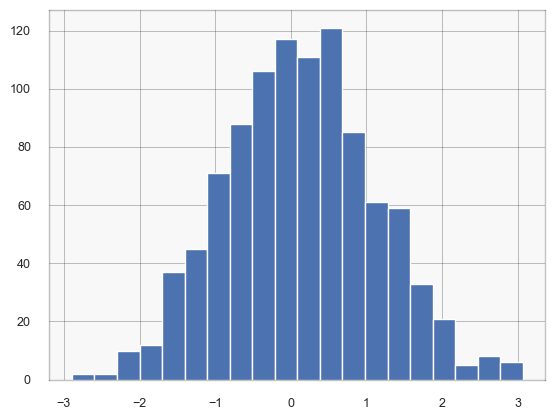

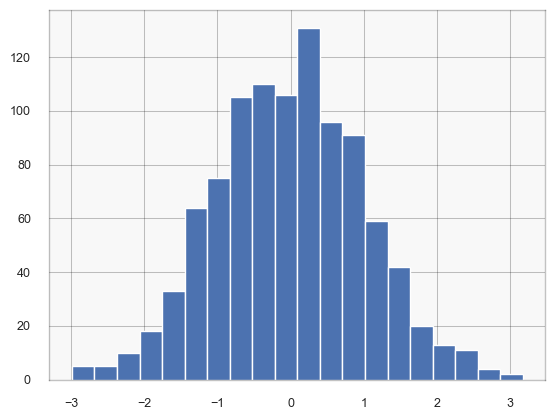

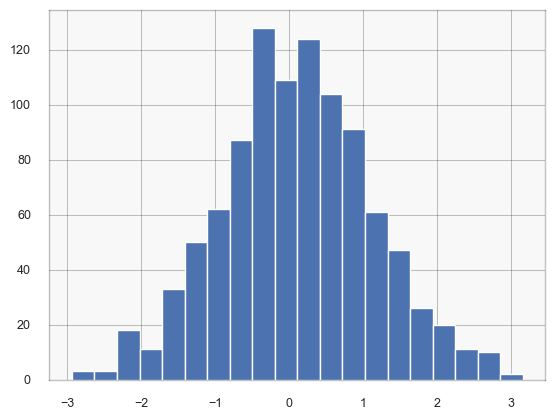

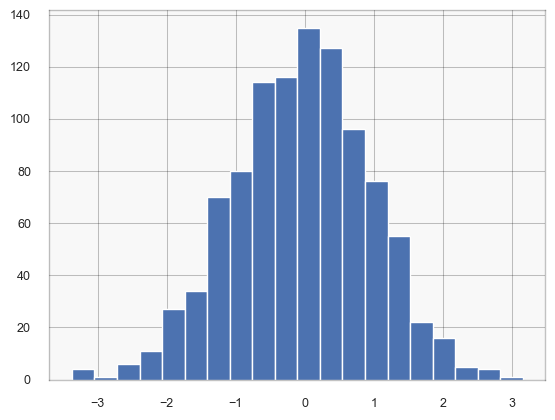

In [13]:
plt.hist(fac, bins=20, color='b')
plt.show()
plt.hist(wh1, bins=20, color='b')
plt.show()
plt.hist(wh2, bins=20, color='b')
plt.show()
plt.hist(wh3, bins=20, color='b')
plt.show()

In [14]:
df1 = pd.DataFrame({"factory":fac, "wh1":wh1, "wh2":wh2, "wh3":wh3})
df1.describe()

,factory,wh1,wh2,wh3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.127218,-0.008492,0.103598,-0.043849
std,0.994209,1.008006,1.017916,0.989153
min,-2.893524,-2.986778,-2.935617,-3.375249
25%,-0.554058,-0.689197,-0.569343,-0.717376
50%,0.117654,-0.003267,0.080752,-0.013772
75%,0.772638,0.682122,0.776865,0.612308
max,3.069747,3.170707,3.157456,3.157156


#### unscaled Action Distribution

In [15]:
fac=[]
wh1=[]
wh2=[]
wh3=[]
for i in range(1000):
    state = env.reset()
    action_raw = ppo_agent.select_action(state)
    action_clip = np.clip(action_raw, -3, 3)
    action = np.zeros(4)
    action[0] = action_clip[0] * sd_fac + m_fac
    action[1:] = action_clip[1:] * sd_wh + m_wh
    
    fac.append(action[0])
    wh1.append(action[1])
    wh2.append(action[2])
    wh3.append(action[3])

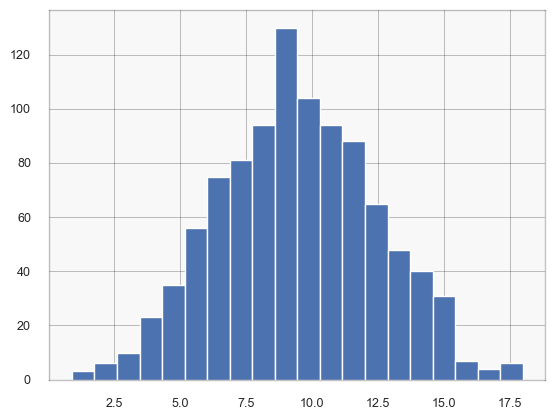

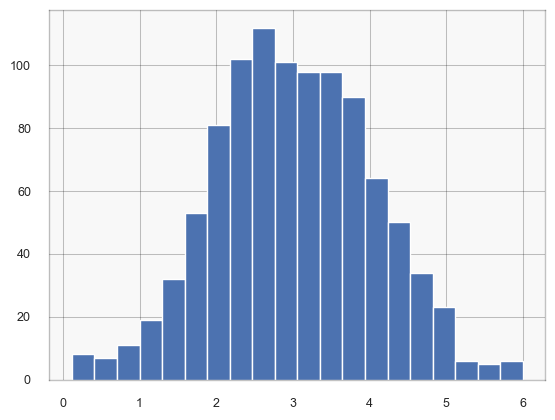

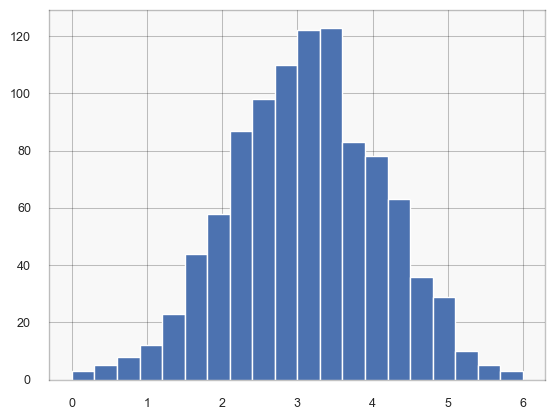

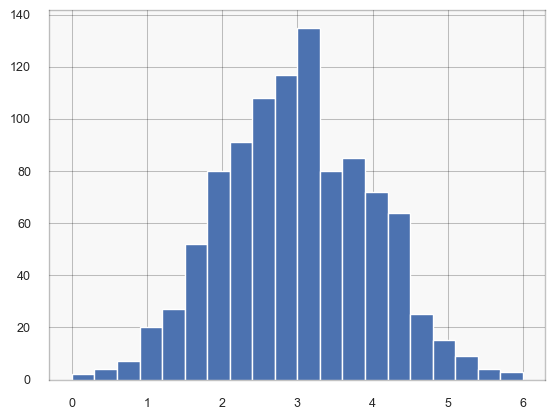

In [16]:
plt.hist(fac, bins=20, color='b')
plt.show()
plt.hist(wh1, bins=20, color='b')
plt.show()
plt.hist(wh2, bins=20, color='b')
plt.show()
plt.hist(wh3, bins=20, color='b')
plt.show()

In [17]:
df1 = pd.DataFrame({"factory":fac, "wh1":wh1, "wh2":wh2, "wh3":wh3})
df1.describe()

,factory,wh1,wh2,wh3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.453887,3.014377,3.114161,2.985103
std,3.004003,1.032359,0.996588,0.980146
min,0.900276,0.116020,0.000000,0.000000
25%,7.370294,2.311310,2.460366,2.304964
50%,9.394273,2.981769,3.115100,2.979764
75%,11.508665,3.717695,3.816745,3.682919
max,18.000000,6.000000,6.000000,6.000000


In [18]:
ppo_agent.buffer.clear()

## Training

In [19]:
df_action = pd.DataFrame(columns=['action_raw', 'action'])
df_record = pd.DataFrame(columns=col_name)

reward_list = []
loss_list = []

In [20]:
################  training  #####################

start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)


time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:

    state = env.reset()
    current_ep_reward = 0


    for t in range(1, max_ep_len+1):

        action_raw = ppo_agent.select_action(state)

        action = np.zeros(4)
        action[0] = action_raw[0] * sd_fac + m_fac
        action[1:] = action_raw[1:] * sd_wh + m_wh
        
        df_action.loc[len(df_action)] = [action_raw, action]    
        
        state, reward, done, _ = env.step(action)


        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_interval == 0:
            df_record.to_csv(log_path+"/record_"+str(time_step)+".csv",index=False)
            df_action.to_csv(log_path+"/action_"+str(time_step)+".csv",index=False)
            
            df_rew = pd.DataFrame({"reward": reward_list})
            df_rew.to_csv(log_path+"/rew_"+str(time_step)+".csv",index=False)
            
            df_loss = pd.DataFrame({"mean_loss": loss_list})
            df_loss.to_csv(log_path+"/loss_"+str(time_step)+".csv",index=False)
            
            df_action = pd.DataFrame(columns=['action_raw', 'action'])
            df_record = pd.DataFrame(columns=col_name)
            reward_list = []
            loss_list = []

        # Print the values
        if time_step % print_interval == 0:
            print("time", time_step)

        # save model weights
        if time_step % cp_interval == 0:
            ppo_agent.save(cp_path+"/ppo_checkpoint_"+str(time_step)+".pth")

#         break; if the episode is over
        if done:
            break

    i_episode += 1

# log_f.close()
env.close()


# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2024-11-27 17:11:41
time 5000
time 10000
--------------------------------------------------------------------------------------------
Action_std 0.95
setting actor output action_std to :  0.95
New_std 0.95
--------------------------------------------------------------------------------------------
time 15000
time 20000
time 25000
--------------------------------------------------------------------------------------------
Action_std 0.8999999999999999
setting actor output action_std to :  0.9
New_std 0.9
--------------------------------------------------------------------------------------------
time 30000
time 35000
time 40000
--------------------------------------------------------------------------------------------
Action_std 0.85
setting actor output action_std to :  0.85
New_std 0.85
--------------------------------------------------------------------------------------------
time 45000
time 50000
time 55000
---------------------------------------------

### Actions while Training
#### Raw training actions

In [23]:
df_action = pd.DataFrame()
for i in range(log_interval,max_training_timesteps+1, log_interval):
    df_temp = pd.read_csv(log_path+"\\action_"+str(i)+".csv")
    df_action = pd.concat([df_action, df_temp])
df_action.reset_index(inplace=True)
df_action.shape

(200000, 3)

In [24]:
def clean_and_parse(row):
    # Replace multiple spaces with a comma
    cleaned_string = re.sub(r'\s+', ',', row.strip())
    # Ensure valid list format
    cleaned_string = cleaned_string.replace('[,', '[').replace(',]', ']')
    # Convert to Python list
    return ast.literal_eval(cleaned_string)

# Apply function to the column
df_action['action_raw'] = df_action['action_raw'].apply(clean_and_parse)
df_action['action'] = df_action['action'].apply(clean_and_parse)

# Print the resulting DataFrame
df_action

,index,action_raw,action
0,0,"[-1.0453801, 1.0350715, -0.23221803, -1.2160031]","[5.86385965, 4.03507137, 2.76778197, 1.78399694]"
1,1,"[-0.36319202, 0.6674828, -1.1700524, 0.7990015]","[7.91042393, 3.66748285, 1.82994759, 3.79900146]"
2,2,"[0.8362636, -0.63060755, 0.2826999, -0.25715804]","[11.50879079, 2.3693924, 3.28269982, 2.74284196]"
3,3,"[0.35604116, -1.771748, -0.8682177, 1.1516411]","[10.06812349, 1.22825205, 2.13178229, 4.15164089]"
4,4,"[0.25407055, -1.851304, -1.0147625, 1.6025517]","[9.76221165, 1.14869595, 1.98523748, 4.60255146]"
...,...,...,...
199995,4995,"[-0.87277675, -0.687449, -0.7417281, -0.59613574]","[6.38166976, 2.31255102, 2.25827193, 2.40386438]"
199996,4996,"[-0.58711445, -1.3533214, -1.193481, 0.7098561]","[7.23865664, 1.64667857, 1.80651903, 3.70985603]"
199997,4997,"[-0.3184638, -0.9408887, 0.27962697, 0.9005277]","[8.04460859, 2.05911136, 3.27962685, 3.90052772]"
199998,4998,"[-0.9909039, -1.2151022, 1.4067574, 0.23362267]","[6.02728826, 1.7848978, 4.40675735, 3.23362255]"


In [25]:
df_action['production_raw'] = df_action['action_raw'].apply(lambda x: x[0])
df_action['wh1_raw'] = df_action['action_raw'].apply(lambda x: x[1])
df_action['wh2_raw'] = df_action['action_raw'].apply(lambda x: x[2])
df_action['wh3_raw'] = df_action['action_raw'].apply(lambda x: x[3])
df_action.head()

,index,action_raw,action,production_raw,wh1_raw,wh2_raw,wh3_raw
0,0,"[-1.0453801, 1.0350715, -0.23221803, -1.2160031]","[5.86385965, 4.03507137, 2.76778197, 1.78399694]",-1.045380,1.035071,-0.232218,-1.216003
1,1,"[-0.36319202, 0.6674828, -1.1700524, 0.7990015]","[7.91042393, 3.66748285, 1.82994759, 3.79900146]",-0.363192,0.667483,-1.170052,0.799002
2,2,"[0.8362636, -0.63060755, 0.2826999, -0.25715804]","[11.50879079, 2.3693924, 3.28269982, 2.74284196]",0.836264,-0.630608,0.282700,-0.257158
3,3,"[0.35604116, -1.771748, -0.8682177, 1.1516411]","[10.06812349, 1.22825205, 2.13178229, 4.15164089]",0.356041,-1.771748,-0.868218,1.151641
4,4,"[0.25407055, -1.851304, -1.0147625, 1.6025517]","[9.76221165, 1.14869595, 1.98523748, 4.60255146]",0.254071,-1.851304,-1.014763,1.602552


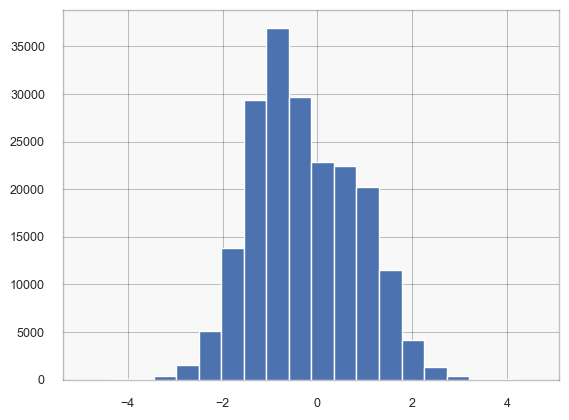

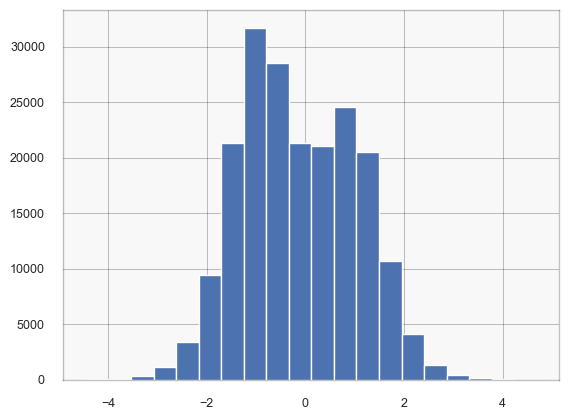

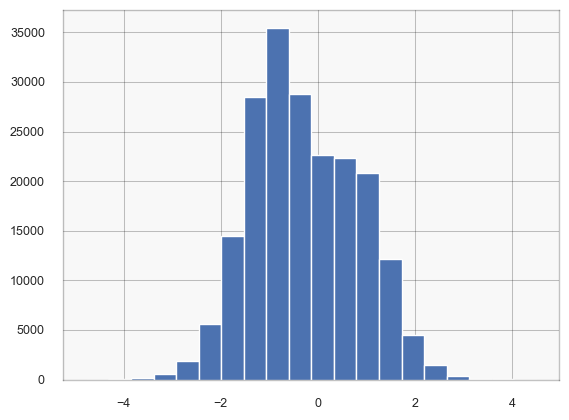

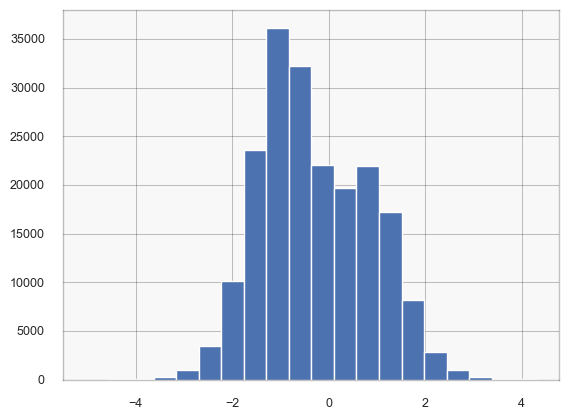

In [26]:
plt.hist(df_action['production_raw'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh1_raw'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh2_raw'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh3_raw'], bins=20, color='b')
plt.show()

In [27]:
df_action[['production_raw', 'wh1_raw', 'wh2_raw', 'wh3_raw']].describe()

,production_raw,wh1_raw,wh2_raw,wh3_raw
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,-0.273023,-0.134842,-0.268160,-0.291375
std,1.088150,1.155986,1.091438,1.127214
min,-4.880677,-4.446669,-4.773581,-5.028931
25%,-1.080914,-1.033000,-1.076157,-1.133123
50%,-0.417612,-0.251662,-0.397441,-0.473529
75%,0.565861,0.802905,0.584726,0.607555
max,4.628108,4.695179,4.511237,4.314197


#### Unscaled training actions

In [28]:
df_action['production'] = df_action['action'].apply(lambda x: x[0])
df_action['wh1'] = df_action['action'].apply(lambda x: x[1])
df_action['wh2'] = df_action['action'].apply(lambda x: x[2])
df_action['wh3'] = df_action['action'].apply(lambda x: x[3])
df_action.head()

,index,action_raw,action,production_raw,wh1_raw,wh2_raw,wh3_raw,production,wh1,wh2,wh3
0,0,"[-1.0453801, 1.0350715, -0.23221803, -1.2160031]","[5.86385965, 4.03507137, 2.76778197, 1.78399694]",-1.045380,1.035071,-0.232218,-1.216003,5.863860,4.035071,2.767782,1.783997
1,1,"[-0.36319202, 0.6674828, -1.1700524, 0.7990015]","[7.91042393, 3.66748285, 1.82994759, 3.79900146]",-0.363192,0.667483,-1.170052,0.799002,7.910424,3.667483,1.829948,3.799001
2,2,"[0.8362636, -0.63060755, 0.2826999, -0.25715804]","[11.50879079, 2.3693924, 3.28269982, 2.74284196]",0.836264,-0.630608,0.282700,-0.257158,11.508791,2.369392,3.282700,2.742842
3,3,"[0.35604116, -1.771748, -0.8682177, 1.1516411]","[10.06812349, 1.22825205, 2.13178229, 4.15164089]",0.356041,-1.771748,-0.868218,1.151641,10.068123,1.228252,2.131782,4.151641
4,4,"[0.25407055, -1.851304, -1.0147625, 1.6025517]","[9.76221165, 1.14869595, 1.98523748, 4.60255146]",0.254071,-1.851304,-1.014763,1.602552,9.762212,1.148696,1.985237,4.602551


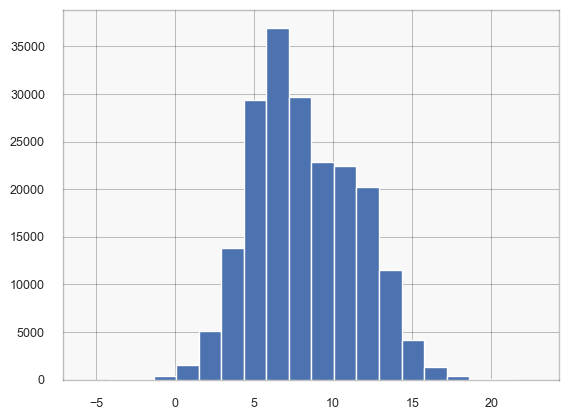

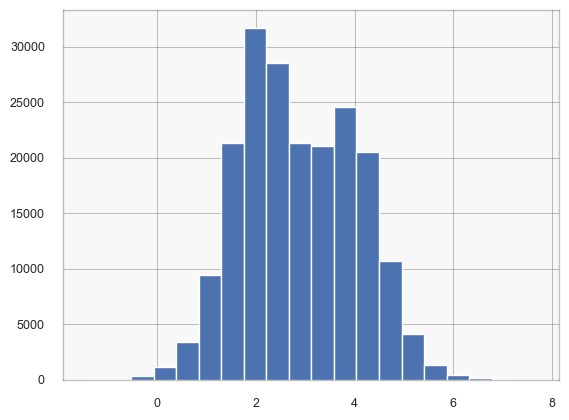

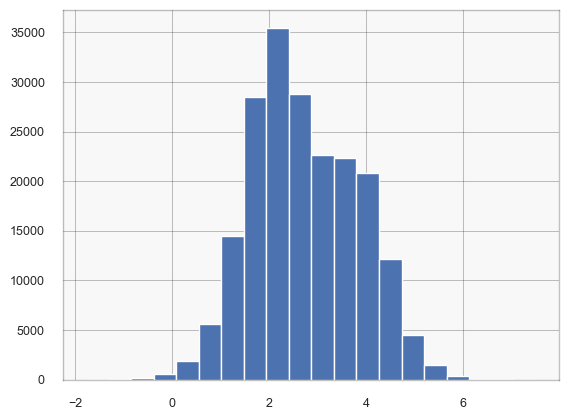

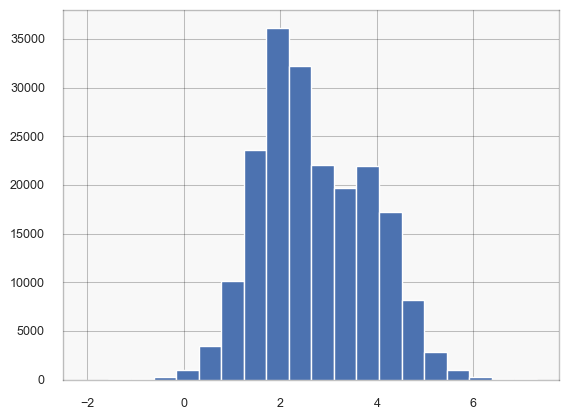

In [29]:
plt.hist(df_action['production'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh1'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh2'], bins=20, color='b')
plt.show()
plt.hist(df_action['wh3'], bins=20, color='b')
plt.show()

In [30]:
df_action[['production', 'wh1', 'wh2', 'wh3']].describe()

,production,wh1,wh2,wh3
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,8.180932,2.865158,2.731840,2.708625
std,3.264449,1.155986,1.091438,1.127214
min,-5.642030,-1.446669,-1.773581,-2.028931
25%,5.757257,1.967000,1.923843,1.866877
50%,7.747164,2.748338,2.602559,2.526471
75%,10.697584,3.802905,3.584726,3.607555
max,22.884325,7.695179,7.511237,7.314197


### Loss Curves

In [ ]:
loss_df = pd.DataFrame()
for i in range(log_interval,max_training_timesteps+1, log_interval):
    df_temp = pd.read_csv(log_path+"\\loss_"+str(i)+".csv")
    loss_df = pd.concat([loss_df, df_temp])
loss_df.reset_index(inplace=True)
loss_df['rolling_loss'] = loss_df['mean_loss'].rolling(100).mean()
loss_df.shape

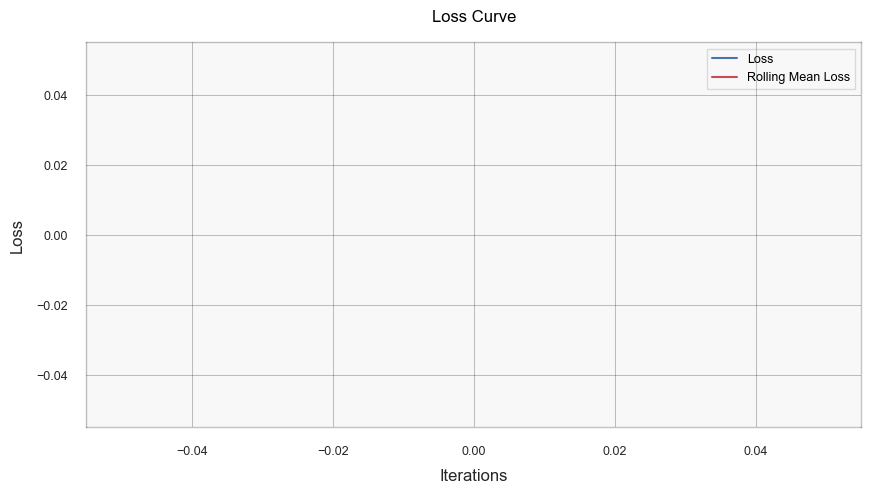

In [32]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(loss_df["mean_loss"], color="b", label="Loss")
plt.plot(loss_df["rolling_loss"], color="r", label="Rolling Mean Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

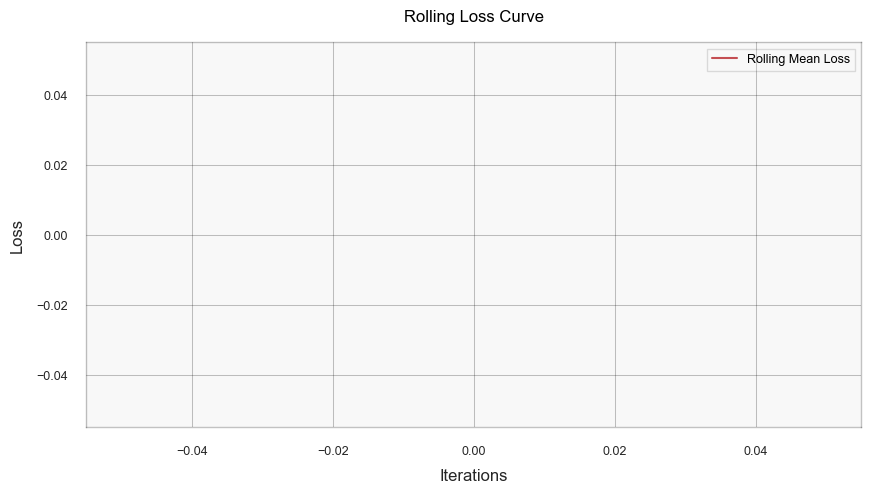

In [33]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("Loss")
# plt.plot(loss_df["loss"], color="b", label="Loss")
plt.plot(loss_df["rolling_loss"], color="r", label="Rolling Mean Loss")
plt.title("Rolling Loss Curve")
plt.legend()
plt.show()

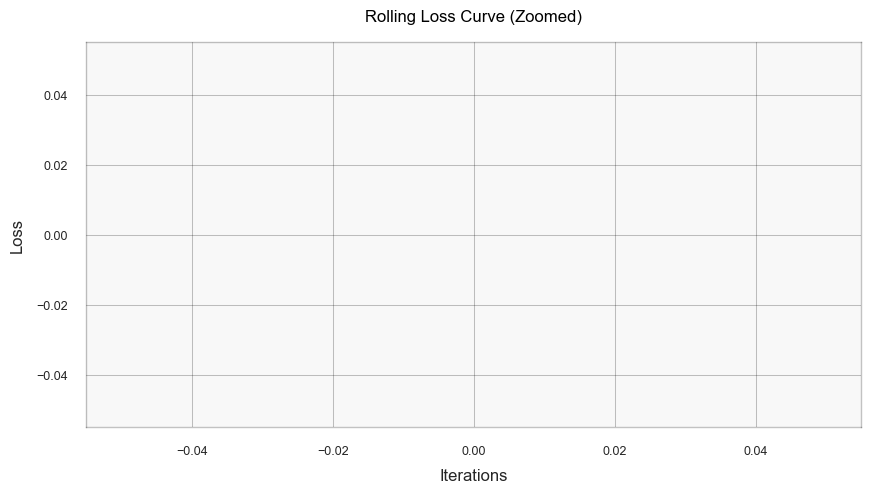

In [34]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.plot(loss_df.loc[len(loss_df) - 2000 :, "rolling_loss"], color="r")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Rolling Loss Curve (Zoomed)")
plt.show()

### Reward Curves

In [ ]:
rew_df = pd.DataFrame()
for i in range(log_interval,max_training_timesteps+1, log_interval):
    df_temp = pd.read_csv(log_path+"\\rew_"+str(i)+".csv")
    rew_df = pd.concat([rew_df, df_temp])
rew_df.reset_index(inplace=True)
rew_df['rolling_rew'] = rew_df['reward'].rolling(100).mean()
rew_df.shape

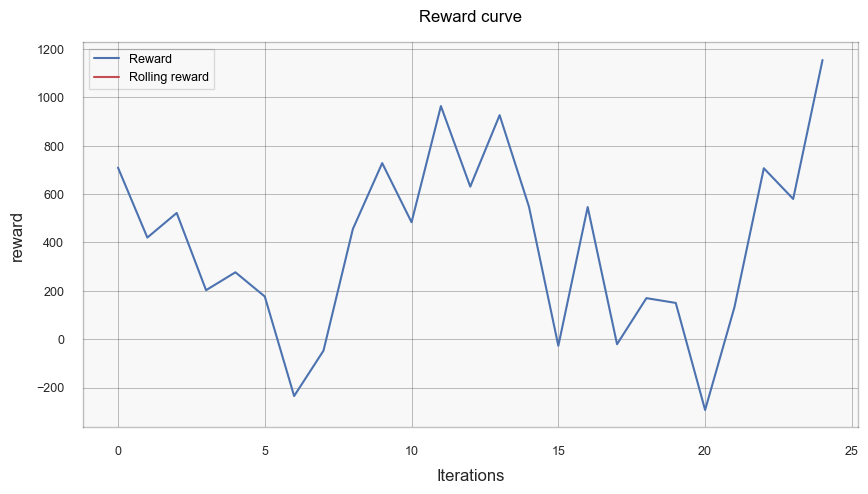

In [36]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'], color="r", label="Rolling reward")
plt.title("Reward curve")
plt.legend()
plt.show()

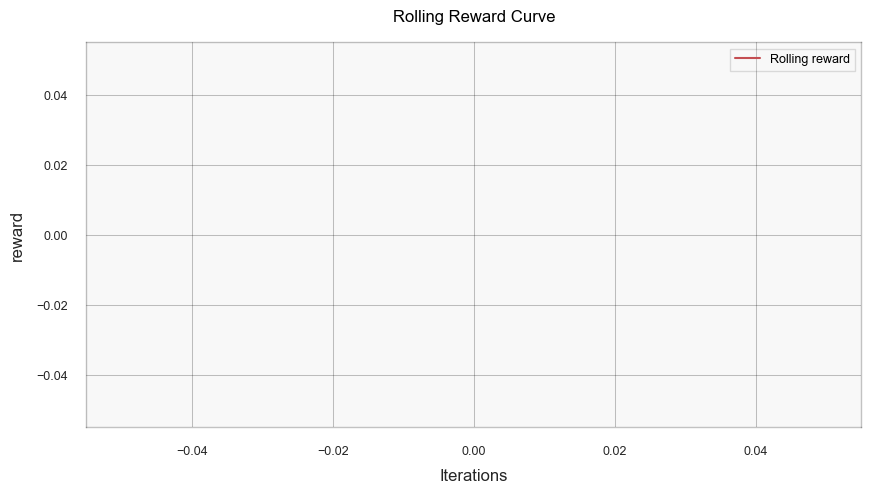

In [37]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
# plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'], color="r", label="Rolling reward")
plt.title("Rolling Reward Curve")
plt.legend()
plt.show()

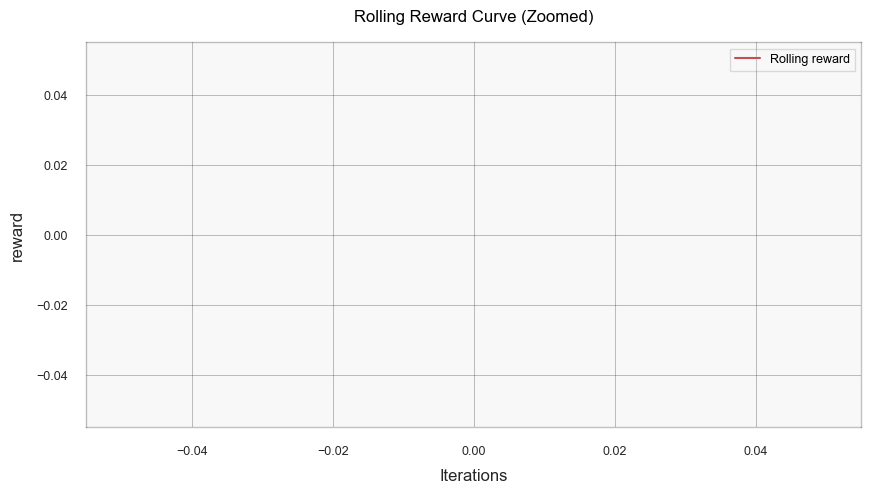

In [38]:
plt.figure(figsize=(10, 5), facecolor="w")
plt.xlabel("Iterations")
plt.ylabel("reward")
# plt.plot(rew_df['reward'], color="b", label="Reward")
plt.plot(rew_df['rolling_rew'][-5000:], color="r", label="Rolling reward")
plt.title("Rolling Reward Curve (Zoomed)")
plt.legend()
plt.show()

## Evaluation
### Environment for test
#### (Here we won't log results in record_df)

In [39]:
class SupplyChainEnvironment_test(object):
    def __init__(self):
        global df_record
        self.backlog_lst = np.zeros(4)
        self.T = 26               # episode duration
        self.warehouse_num = 3
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units

        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

#         self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.storage_capacities = np.array([60.0, 20.0, 30.0, 40.0])
        

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
#         self.penalty_unit_cost = self.unit_price

        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(
        self.warehouse_num,
        self.T,
        list(self.demand_history),
        self.storage_capacities,  # Pass storage capacities
        self.d_max  # Pass demand max
    )

    def step(self, state, action):
#         print(self.t)
        
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)
        
        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        backlog_cost = self.unit_price * np.sum(self.backlog_lst)
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )

        reward = total_revenue - total_production_cost - total_storage_cost - backlog_cost - total_transportation_cost
        reward_list.append(reward)
        
        # calculating the next state
        next_state = State(self.warehouse_num, self.T, list(self.demand_history),self.storage_capacities, self.d_max, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0])
        factory_stock_original = max(next_state.factory_stock, 0)
        backlog_factory = factory_stock_original - next_state.factory_stock
        self.backlog_lst[0] = backlog_factory
        next_state.factory_stock = factory_stock_original

        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])
            warehouse_stock_original = max(next_state.warehouse_stock[w],0)
            backlog_wh = warehouse_stock_original - next_state.warehouse_stock[w]
            self.backlog_lst[w+1] = backlog_wh
            next_state.warehouse_stock[w] = warehouse_stock_original
        next_state.demand_history = list(self.demand_history)
        
        self.t += 1
        self.demand_history.append(demands)
        
        record_lst = [self.t, action.production_level, action.shippings_to_warehouses, demands, total_revenue, total_production_cost, total_storage_cost, backlog_cost, total_transportation_cost, reward, self.backlog_lst, next_state.factory_stock]
        df_record.loc[len(df_record)] = record_lst

        return next_state, reward, self.t == self.T - 1


In [40]:
class SimpleSupplyChain(gym.Env):
    def __init__(self):
        self.reset()
        self.action_space = Box(low=0.0, high=18.0, shape=(self.supply_chain.warehouse_num + 1,), dtype=np.float32)
        self.observation_space = Box(low=-1000.0, high=1000.0, shape=(len(self.supply_chain.initial_state().to_array()),), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment_test()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

In [41]:
env = SimpleSupplyChain()

In [42]:
def simulate_episode_with_q(env: SimpleSupplyChain, ppo_agent: ppo_agent) -> list:
    """Simulates a single episode using the Q-network."""
    state = env.reset()
    transitions = []

    for t in range(max_ep_len):
#         state_array = state.to_array()
#         action_values = q_network.predict(state_array)
#         action = select_action_from_q(action_values)
        action = ppo_agent.select_action(state)
        action[0] = action[0] * sd_fac + m_fac
        action[1] = action[1] * sd_wh + m_wh
        action[2] = action[2] * sd_wh + m_wh
        action[3] = action[3] * sd_wh + m_wh
        

        next_state, reward, _, _ = env.step(action)
        transitions.append([state, action, reward])
        state = next_state

    return transitions

In [43]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions_rl(transitions):
    st_lst = []
    act_lst = []
    rw_lst = []
    for i in range(len(transitions)):
        st_lst.append(transitions[i][0])
        act_lst.append(transitions[i][1])    
        rw_lst.append(transitions[i][2])    
    
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2
    print(f"Return is {sum(rw_lst)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(max_ep_len), list(map(lambda s: s[0], st_lst)), c='purple', alpha=0.5)

    for w in range(3):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(max_ep_len), list(map(lambda s: s[w+1], st_lst)), c='purple', alpha=0.5)

    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(max_ep_len), list(map(lambda a: a[0], act_lst)), c='blue', alpha=0.5)

    for w in range(3):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(max_ep_len), list(map(lambda a: a[w+1], act_lst)), c='blue', alpha=0.5)

    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(max_ep_len), rw_lst, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(max_ep_len), np.cumsum(rw_lst), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

### Evaluation result

Episode 1 Return: 9681.544191598892
Episode 2 Return: 9348.468704462051
Episode 3 Return: 8746.8364443779
Episode 4 Return: 9157.922076582909
Episode 5 Return: 9413.175580978394
Episode 6 Return: 9182.493027091026
Episode 7 Return: 8836.892834305763
Episode 8 Return: 8972.17827284336
Episode 9 Return: 8990.198966145515
Episode 10 Return: 8446.37636744976
Best Episode Return: 9681.544191598892
Return is 9257.050685763359


C:\Users\ajit.mishra\AppData\Local\Temp\ipykernel_14248\687611883.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plots_n, 1, n)


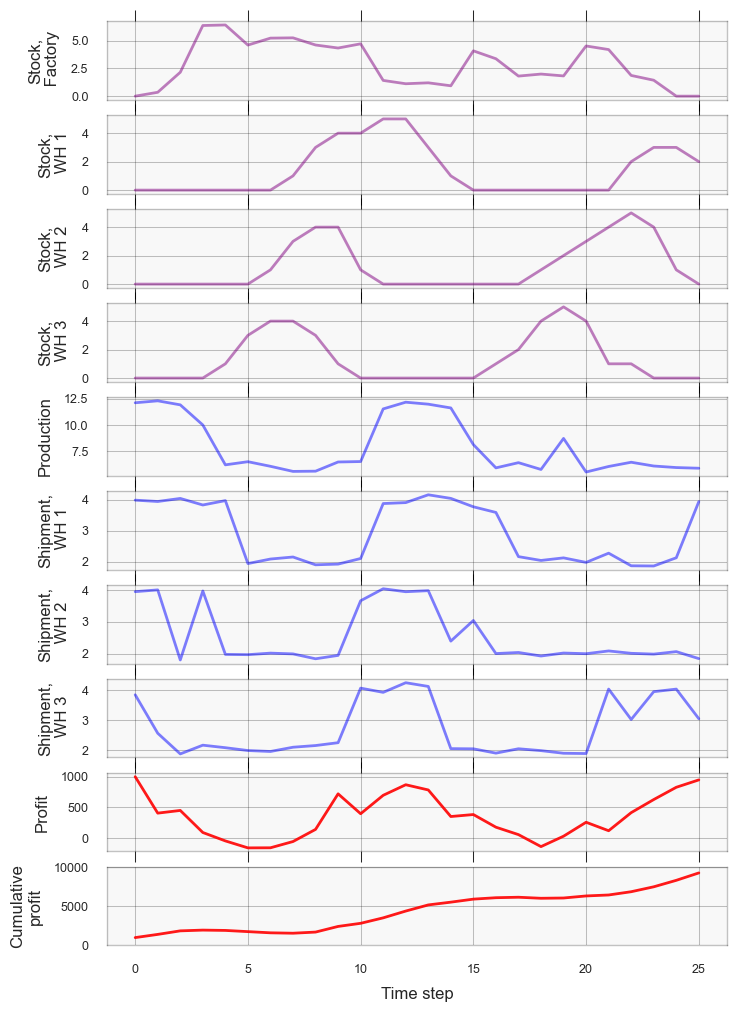

In [45]:
# Initialize variables
best_return = float('-inf')
best_transitions = None
returns_list_rl = []

# Run the simulation for 20 episodes
for episode in range(100):
    env = SimpleSupplyChain()
    state = env.reset()
    transitions_rl = []

    for t in range(max_ep_len):
#         state_array = state.to_array()
#         action_values = q_network.predict(state_array)
#         action = select_action_from_q(action_values)
        action = ppo_agent.select_action(state)
        action[0] = action[0] * sd_fac + m_fac
        action[1] = action[1] * sd_wh + m_wh
        action[2] = action[2] * sd_wh + m_wh
        action[3] = action[3] * sd_wh + m_wh


        next_state, reward, _, _ = env.step(action)
        transitions_rl.append([state, action, reward])
        state = next_state
    # Calculate the return for the current episode
    episode_return = sum(transition[2] for transition in transitions_rl)
    returns_list_rl.append(episode_return)
    print(f"Episode {episode + 1} Return: {episode_return}")

    # Update the best transitions if the current return is the highest
    if episode_return > best_return:
        best_return = episode_return
        best_transitions = transitions_rl

print(f"Best Episode Return: {best_return}")

# Visualize the transitions of the best episode
if best_transitions:
    visualize_transitions_rl((best_transitions))

In [ ]:
plt.hist(returns_list_sq, bins=20, color='b')
plt.xlabel("Cumulative Episode Reward")
plt.ylabel("frequency")
plt.title("Histogrsm of Episodic Profit (RL)")
plt.grid(False)
plt.show()

In [ ]:
plt.hist(returns_list_rl, bins=20, edgecolor=None, color='r', alpha=0.5, label='RL')
plt.hist(returns_list_sq, bins=20, edgecolor=None, color='b', alpha=0.5, label='SQ Policy')
plt.legend()
plt.xlabel("Cumulative Episode Reward")
plt.ylabel("Frequency")
plt.title("Histogrsm of Episodic Profit")
plt.grid(False)
plt.show()

In [ ]:
df_eval = pd.DataFrame({"rl":returns_list_rl})
df_eval.describe()

# Baseline Policy - (s,Q)

In [65]:
# We use (s, Q)-policy as a baseline
# The policy is: Order your Economic Order Quantity Q, every time your inventory
# position drops below s (Reorder Point or Safety Stock).

class SQPolicy(object):
    def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
        self.factory_safety_stock = factory_safety_stock
        self.factory_reorder_amount = factory_reorder_amount
        self.safety_stock = safety_stock
        self.reorder_amount = reorder_amount

    def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]

        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock:
            action.production_level = self.factory_reorder_amount
        else:
            action.production_level = 0
        return action

def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

In [66]:
env = SupplyChainEnvironment_test()

In [67]:
def func(p):
    policy = SQPolicy(
        p['factory_s'],
        p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    return np.mean(simulate(env, policy, num_episodes = 30))

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          { "name": "factory_s",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "factory_Q",   "type": "range",  "bounds": [0.0, 30.0], },
          { "name": "w1_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w1_Q",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w2_Q",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_s",        "type": "range",  "bounds": [0.0, 20.0], },
          { "name": "w3_Q",        "type": "range",  "bounds": [0.0, 20.0], },
        ],
        evaluation_function=func,
        minimize=False,
        total_trials=200,
    )

[INFO 11-27 21:07:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-27 21:07:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-27 21:07:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-27 21:07:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

[INFO 11-27 21:18:35] ax.service.managed_loop: Running optimization trial 13...
C:\Users\ajit.mishra\AppData\Local\anaconda3\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 11-27 21:19:30] ax.service.managed_loop: Running optimization trial 14...
C:\Users\ajit.mishra\AppData\Local\anaconda3\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 11-27 21:20:18] ax.service.managed_loop: Running optimization trial 15...
C:\Users\ajit.mishra\AppData\Local\anaconda3\Lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomMo

[INFO 11-27 22:39:14] ax.service.managed_loop: Running optimization trial 101...
[INFO 11-27 22:40:12] ax.service.managed_loop: Running optimization trial 102...
[INFO 11-27 22:41:11] ax.service.managed_loop: Running optimization trial 103...
[INFO 11-27 22:42:10] ax.service.managed_loop: Running optimization trial 104...
[INFO 11-27 22:43:10] ax.service.managed_loop: Running optimization trial 105...
[INFO 11-27 22:44:09] ax.service.managed_loop: Running optimization trial 106...
[INFO 11-27 22:45:11] ax.service.managed_loop: Running optimization trial 107...
[INFO 11-27 22:46:12] ax.service.managed_loop: Running optimization trial 108...
[INFO 11-27 22:47:13] ax.service.managed_loop: Running optimization trial 109...
[INFO 11-27 22:48:14] ax.service.managed_loop: Running optimization trial 110...
[INFO 11-27 22:49:14] ax.service.managed_loop: Running optimization trial 111...
[INFO 11-27 22:50:13] ax.service.managed_loop: Running optimization trial 112...
[INFO 11-27 22:51:14] ax.ser

In [68]:
display(best_parameters)
display(best_values)

{'factory_s': 0.0,
 'factory_Q': 27.440989782817855,
 'w1_s': 6.203364636936401,
 'w1_Q': 11.31605591137037,
 'w2_s': 20.0,
 'w2_Q': 1.1811325067436227,
 'w3_s': 2.287052762868597,
 'w3_Q': 5.1454291014399285}

({'objective': 7242.272407011989},
 {'objective': {'objective': 246164.1093148727}})

In [69]:
optimized_policy = SQPolicy(
    factory_safety_stock=best_parameters['factory_s'],
    factory_reorder_amount=best_parameters['factory_Q'],
    safety_stock=[best_parameters['w1_s'], best_parameters['w2_s'], best_parameters['w3_s']],
    reorder_amount=[best_parameters['w1_Q'], best_parameters['w2_Q'], best_parameters['w3_Q']]
)

Reward: mean 7026.61784252304, standard deviation 511.13950552258325


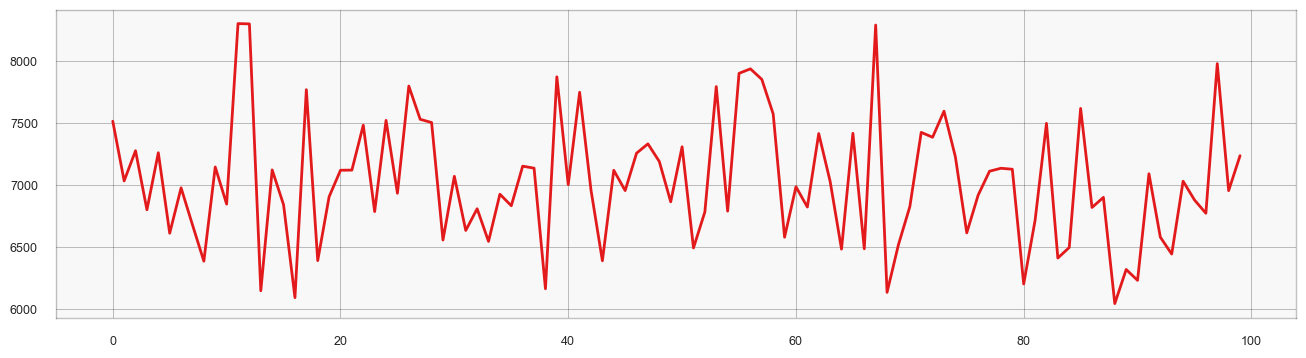

In [70]:
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
#policy_sQ = SQPolicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, optimized_policy, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

In [71]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions_sq(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)

    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)

    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

Return is 6304.5053658255965


C:\Users\ajit.mishra\AppData\Local\Temp\ipykernel_14248\3567164686.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plots_n, 1, n)


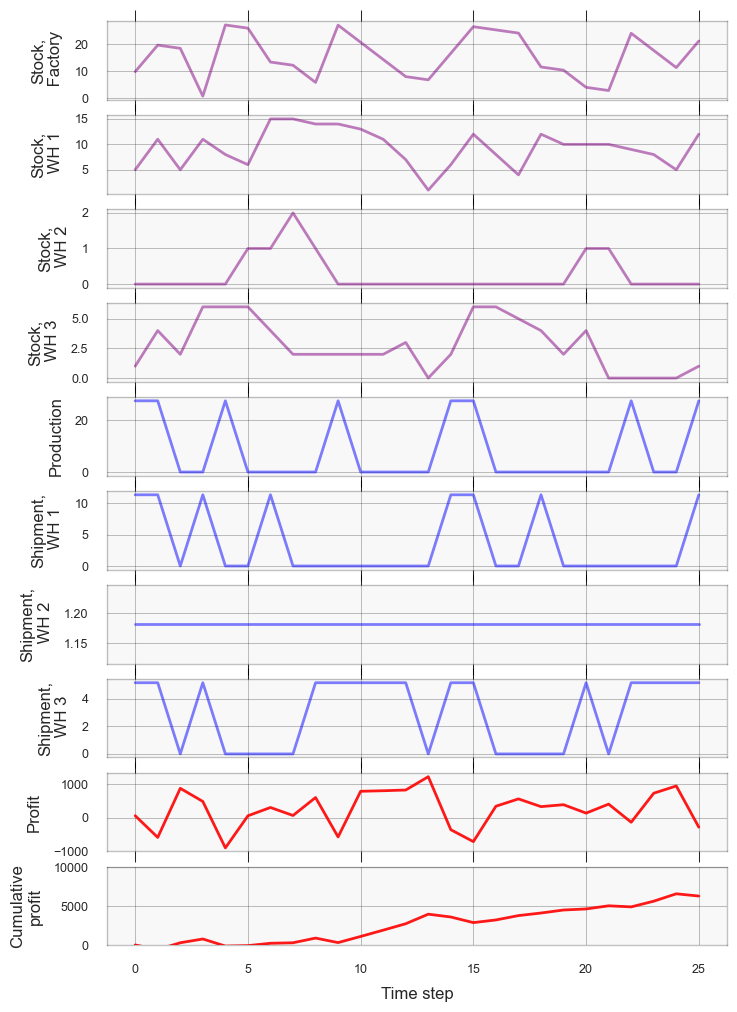

In [72]:
best_return = float('-inf')
best_transitions = None
returns_list_sq = []

# Run the simulation for 20 episodes
for episode in range(100):
    env = SupplyChainEnvironment_test()
    state = env.reset()
#     transitions_sq = []

    transitions_sq = simulate_episode(env, optimized_policy)
    
    # Calculate the return for the current episode
    episode_return = sum(transition[2] for transition in transitions_sq)
    returns_list_sq.append(episode_return)
    print(f"Episode {episode + 1} Return: {episode_return}")

    # Update the best transitions if the current return is the highest
    if episode_return > best_return:
        best_return = episode_return
        best_transitions = transitions_sq

print(f"Best Episode Return: {best_return}")

# Visualize the transitions of the best episode
if best_transitions:
    visualize_transitions_sq(np.array(best_transitions))

In [ ]:
plt.hist(returns_list_sq, bins=20, color='b')
plt.xlabel("Cumulative Episode Reward")
plt.ylabel("frequency")
plt.title("Histogrsm of Episodic Profit (SQ Policy)")
plt.grid(False)
plt.show()

In [ ]:
plt.hist(returns_list_rl, bins=20, edgecolor=None, color='r', alpha=0.5, label='RL')
plt.hist(returns_list_sq, bins=20, edgecolor=None, color='b', alpha=0.5, label='SQ Policy')
plt.legend()
plt.xlabel("Cumulative Episode Reward")
plt.ylabel("Frequency")
plt.title("Histogram of Episodic Profit")
plt.grid(False)
plt.show()

In [ ]:
df_eval['sq'] = returns_list_sq
df_eval.describe()

### Optimization of (s, Q)-policy parameters using brute force search

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1,
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

# env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    policy = SQPolicy(
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env1, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

# Optimizing the Policy Using Reinforcement Learning / RLlib

In [ ]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512]
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000

    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()

# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] )
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))